# Summary

### In this notebook we apply the Hard and Double-Hard Debias process on pretrained word2vec embeddings utilized in T Manzini et al. for Race.  We then perform several studies including t-SNE and KMeans cluster analysis, Race-Specific Analogy Evaluation, and calculate the Mean Average Cosine score as performed in the Manzini etl al study, with implementations derived from https://github.com/TManzini/DebiasMulticlassWordEmbedding.

In [1]:
from common.biasOps import identify_bias_subspace, project_onto_subspace
from common.loader import load_def_sets
from common.neighborAnalysis import get_most_biased, cluster
from common.util import load_legacy_w2v_as_keyvecs, tsne_plot, pruneWordKeyVecs
from gensim.models.keyedvectors import Word2VecKeyedVectors

import json
import matplotlib.pyplot as plt
import numpy as np
import string 

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## Initialize Embeddings, Subspace, Defining/Equality Sets, Biased/Neutral Words

In [2]:
def_sets = load_def_sets('data/vocab/race_attributes_optm.json')
wv_pt = load_legacy_w2v_as_keyvecs("data/data_vocab_race_pre_trained.w2v")
targets = json.load(open('data/professions.json', 'r'))
targets = [x[0] for x in targets]

original_vectors = pruneWordKeyVecs(wv_pt)
embed_dim = wv_pt.vector_size

In [3]:
# obtain the bias subspace with all defining sets using the original model
subspace = identify_bias_subspace(original_vectors, def_sets, 2, embed_dim)

# get all positive and negative words words within the subspace (moving towards or away from some race)
positive_words, negative_words = get_most_biased(original_vectors, subspace[0], 1000)

# get all biased words (minus those in the defining/equality set)
positive_words = [word for word, sim in positive_words]
negative_words = [word for word, sim in negative_words]

# use the defining set as the equality set 
eq_sets = [set for _, set in def_sets.items()]

biased_words = set(positive_words + negative_words) - set(np.array(eq_sets).flatten())

# 1 for more positive biased words, 0 for more negative biased words
y_true = [ 1 if word in positive_words else 0 for word in biased_words]


In [4]:
from common.evalBias import generateAnalogies
from common.loader import load_analogy_templates

# load our test neutral words, consistent with original multiclass research
analogyTemplates = load_analogy_templates('data/vocab/race_attributes_optm.json','role')
neutral_words = []
for value in analogyTemplates.values():
    neutral_words.extend(value)

## Evaluate Pretrained (Original) Embeddings - Word2Vec Model

In [5]:
# What is the Precision in determining positive vs negative bias? High precision means high bias/clustering

x_orig = [original_vectors[word] for word in biased_words] 
precision_orig = cluster(X1=np.array(x_orig), random_state=3, y_true=y_true, num=2)
precision_orig

0.9984939759036144

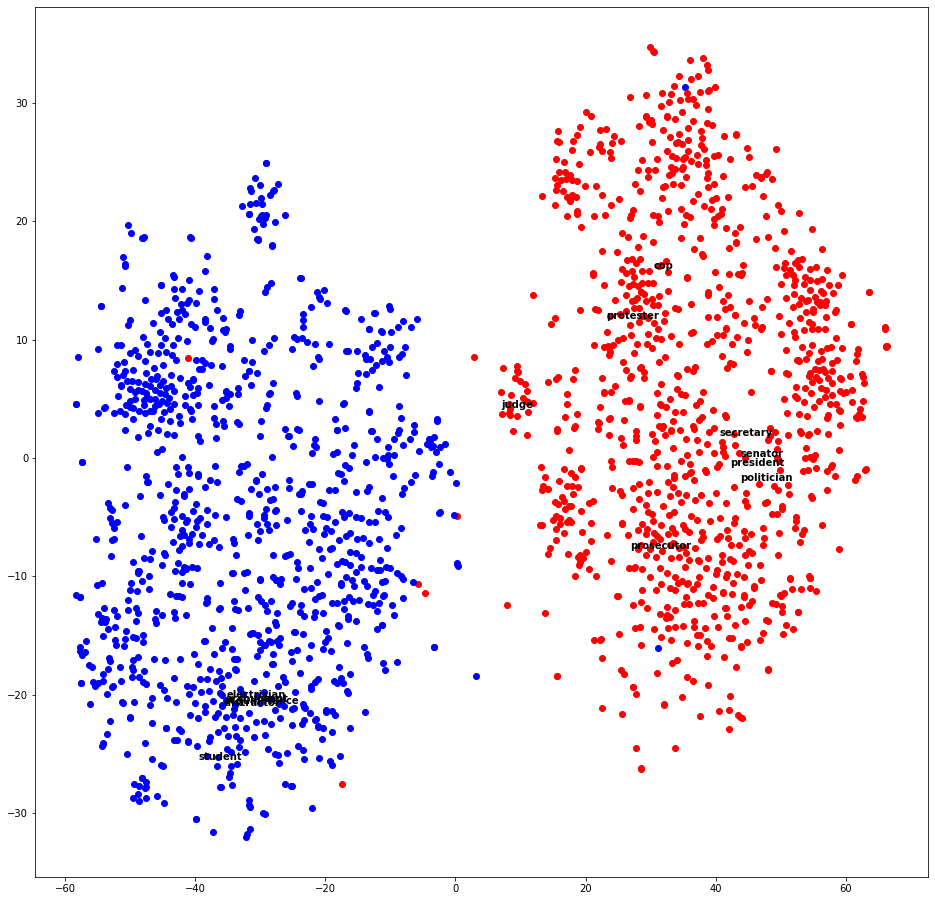

In [6]:
# Perform TSNE Clustering with original pretrained embedding to determine if clusters 
# are still recognized between positive and negatively biased words. Neutral words are labeled

tsne_plot(wv_pt, biased_words, set(targets), y_true) 

## Generate & Evaluate Hard Debiased  Embedding - Word2Vec Model

In [7]:
from common.biasOps import neutralize_and_equalize
from common.util import convert_legacy_to_keyvec

# Execute Hard Debias on original pretrained embeddings
full_words = set([word for word, _ in original_vectors.items()]) - set(np.array(eq_sets).flatten())
debiased_vectors = neutralize_and_equalize(original_vectors, full_words, eq_sets, subspace, embed_dim)
wv_hd = convert_legacy_to_keyvec(debiased_vectors)

In [8]:
# What is the Precision in the Hard Debias embeddings? High precision means high bias/clustering

x_hd = [debiased_vectors[word] for word in biased_words] 
precision_hd = cluster(X1=np.array(x_hd), random_state=3, y_true=y_true, num=2)
precision_hd

0.6631526104417671

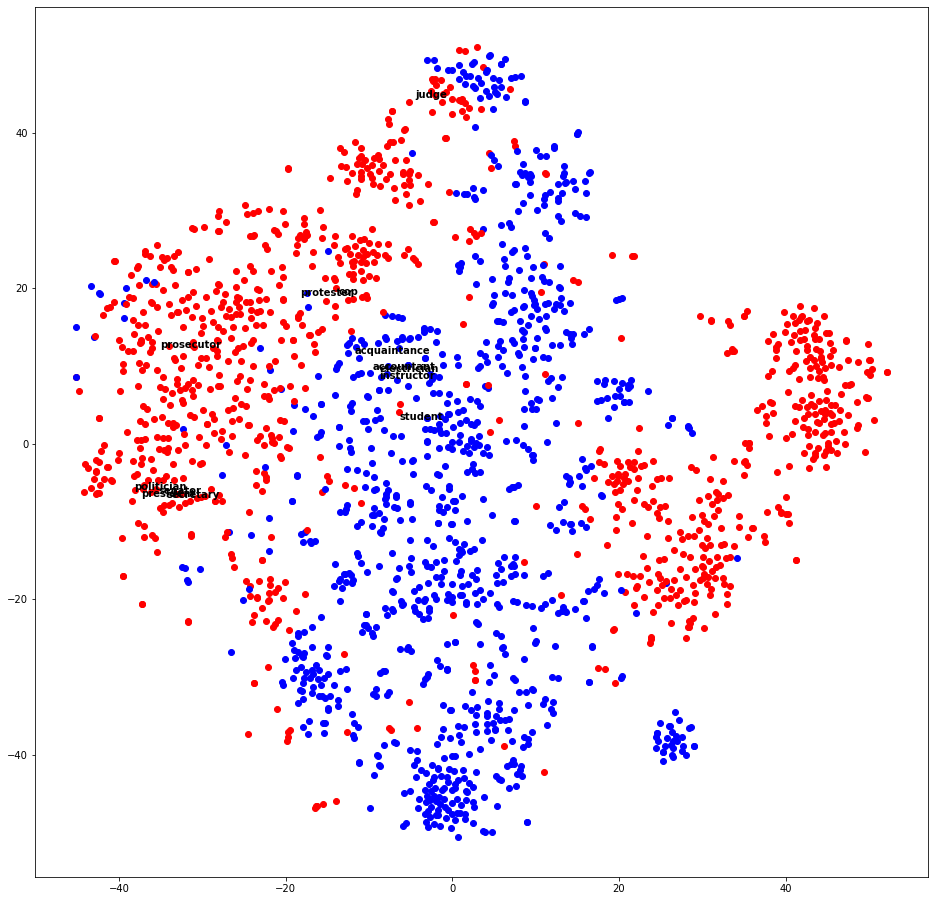

In [9]:
# TSNE Clustering with Hard Debias to determine if clusters 
# are still recognized between positive and negatively biased words. Neutral words are labeled

tsne_plot(wv_hd, biased_words, set(targets), y_true) 

## Generate Double-Hard Debias - Word2Vec Model

In [10]:
# Execute Double Hard Debias and capture precision and new word embedding
from common.biasOps import calculate_main_pca_components, neutralize_and_equalize_with_frequency_removal
from common.util import convert_legacy_to_keyvec

# calculate decentralized embedding pca
main_pca = calculate_main_pca_components(wv_pt).components_


# run debias for each principal component and capture best precision
precisions = []
debiases = []

for pc in main_pca:
    debiased_frequency = neutralize_and_equalize_with_frequency_removal(original_vectors, biased_words, eq_sets, subspace, embed_dim, pc)
    x_dhd = [debiased_frequency[word] for word in biased_words]    
    precisions.append(cluster(X1=np.array(x_dhd), random_state=3, y_true=y_true, num=2))
    debiases.append(debiased_frequency)

# use debias with the lowest precision for further study
db = debiases[np.argmin(precisions)]
wv_dhd = convert_legacy_to_keyvec(db)

## Evaluate Double-Hard Debias - Word2Vec Model

In [11]:
# What is the precision when attempting to estimte cluster bias from the double hard debias embedding
x_dhd = [db[word] for word in biased_words] 
precision_dhd = cluster(X1=np.array(x_dhd), random_state=3, y_true=y_true, num=2)
precision_dhd

0.5336345381526104

In [12]:
# Apply Double Hard using best precision
pca = main_pca[np.argmin(precisions)]
full_words = set([word for word, _ in original_vectors.items()]) - set(np.array(eq_sets).flatten())
double_hard_vectors = neutralize_and_equalize_with_frequency_removal(original_vectors, full_words, eq_sets, subspace, embed_dim, pca)
wv_dhd = convert_legacy_to_keyvec(double_hard_vectors)

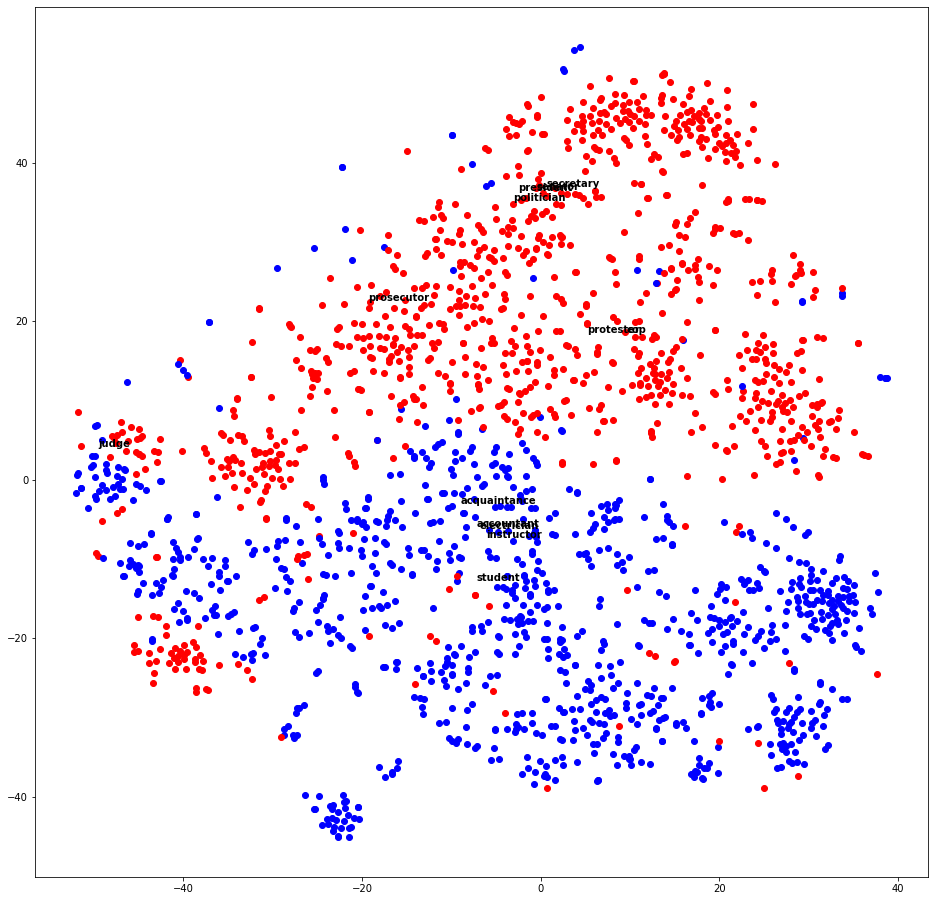

In [13]:
# TSNE Clustering with Double Hard Debias
tsne_plot(wv_dhd, biased_words, set(targets), y_true) 

## Evaluation - Generate Analogies

In [14]:
biasedAnalogies, biasedAnalogyGroups = generateAnalogies(analogyTemplates,wv_pt)
topAnalogies = 10

print("Biased Analogies (0-" + str(topAnalogies) + ")")
for score, analogy, _ in biasedAnalogies[:topAnalogies]:
    print(score, analogy)

Biased Analogies (0-10)
0.7440957 asian is to laborer as caucasian is to maxim
0.7242655 asian is to laborer as caucasian is to quorum
0.722782 asian is to engineer as caucasian is to sociologist
0.72159934 black is to runner as caucasian is to fricative
0.7141854 asian is to laborer as caucasian is to forgery
0.71230006 black is to runner as caucasian is to rifleman
0.710995 black is to runner as caucasian is to alveolar
0.7099743 black is to runner as caucasian is to para
0.70986015 black is to runner as caucasian is to infinitive
0.70933586 asian is to engineer as caucasian is to astronomer


In [15]:
hardDebiasedAnalogies, hardDebiasedAnalogyGroups = generateAnalogies(analogyTemplates,wv_hd)
print("Hard Debiased Analogies (0-" + str(topAnalogies) + ")")
for score, analogy, _ in hardDebiasedAnalogies[:topAnalogies]:
    print(score, analogy)

Hard Debiased Analogies (0-10)
0.93013847 caucasian is to manager as black is to manager
0.9234072 black is to runner as caucasian is to runner
0.9222166 caucasian is to executive as black is to executive
0.91670394 black is to criminal as caucasian is to criminal
0.91662484 black is to musician as caucasian is to musician
0.91192937 caucasian is to leader as black is to leader
0.90528667 caucasian is to farmer as black is to farmer
0.89850247 black is to slave as caucasian is to slave
0.89536214 black is to homeless as caucasian is to homeless
0.87904006 caucasian is to hillbilly as black is to hillbilly


In [16]:
doubleHardDebiasedAnalogies, doubleHardDebiasedAnalogyGroups = generateAnalogies(analogyTemplates,wv_dhd)
print("Double-Hard Debiased Analogies (0-" + str(topAnalogies) + ")")
for score, analogy, _ in doubleHardDebiasedAnalogies[:topAnalogies]:
    print(score, analogy)

Double-Hard Debiased Analogies (0-10)
0.91991407 black is to runner as caucasian is to runner
0.9197759 caucasian is to manager as black is to manager
0.9155592 caucasian is to executive as black is to executive
0.91118675 black is to criminal as caucasian is to criminal
0.91083544 black is to musician as caucasian is to musician
0.90370685 caucasian is to leader as black is to leader
0.8977366 caucasian is to farmer as black is to farmer
0.89284015 black is to slave as caucasian is to slave
0.87976694 black is to homeless as caucasian is to homeless
0.8663415 caucasian is to hillbilly as black is to hillbilly


## Evaluation - MAC Scoring

In [17]:
from common.evalBias import multiclass_evaluation
from common.loader import load_eval_terms
from scipy.stats import ttest_rel

evalTargets, evalAttrs = load_eval_terms('data/vocab/race_attributes_optm.json','role')

print("Biased Evaluation Results")
biasedMAC, biasedDistribution = multiclass_evaluation(wv_pt, evalTargets, evalAttrs)
print("Biased MAC:", biasedMAC)

print("\nHard Debiased Evaluation Results")
hardDebiasedMAC, hardDebiasedDistribution = multiclass_evaluation(wv_hd, evalTargets, evalAttrs)
print("Hard Debiased MAC:", hardDebiasedMAC)

print("\nDouble-Hard Debiased Evaluation Results")
doubleHardDebiasedMAC, doubleHardDebiasedDistribution = multiclass_evaluation(wv_dhd, evalTargets, evalAttrs)
print("Double Hard Debiased MAC:", doubleHardDebiasedMAC)


Biased Evaluation Results
Biased MAC: 0.8920888686608696

Hard Debiased Evaluation Results
Hard Debiased MAC: 0.9247065471674971

Double-Hard Debiased Evaluation Results
Double Hard Debiased MAC: 0.9185152568035172


In [18]:
hd_statistics, hd_pvalue = ttest_rel(biasedDistribution, hardDebiasedDistribution)
dhd_statistics, dhd_pvalue = ttest_rel(biasedDistribution, doubleHardDebiasedDistribution)


print("Hard Debiased Cosine difference t-test", hd_pvalue)
print("Double Hard Debiased Cosine difference t-test", dhd_pvalue)


Hard Debiased Cosine difference t-test 0.041065741706804396
Double Hard Debiased Cosine difference t-test 0.0891923470526098


## Further Experimentation within Defining Sets 

### As an additional study we look to pull biased words by isolating individual defining sets and evaluate cluster performance against the embeddings 

In [19]:
def get_race_directions(classes, embed_dim, word_vectors):
    vects = np.zeros((len(classes), embed_dim))
    for i, word in enumerate(classes):
        if word not in word_vectors:
            raise ValueError(word)
        vects[i] = word_vectors[word]
    mean = vects.mean(0)

    directions = np.zeros((len(classes), embed_dim))
    for i, word in enumerate(classes):
        directions[i] = word_vectors[word] - mean
        directions[i] = directions[i] / np.linalg.norm(directions[i])
        
    return directions 

def generate_max_biased_words(classes, vectors, directions, num_words):
    
    positive_bias, negative_bias = get_most_biased(vectors, directions, n_biased=num_words)
    positive_words = [x[0] for x in positive_bias]
    negative_words = [x[0] for x in negative_bias]
    return positive_words, negative_words



tSNE Clustering Plot (Original Embedding): ['black', 'caucasian', 'asian']:


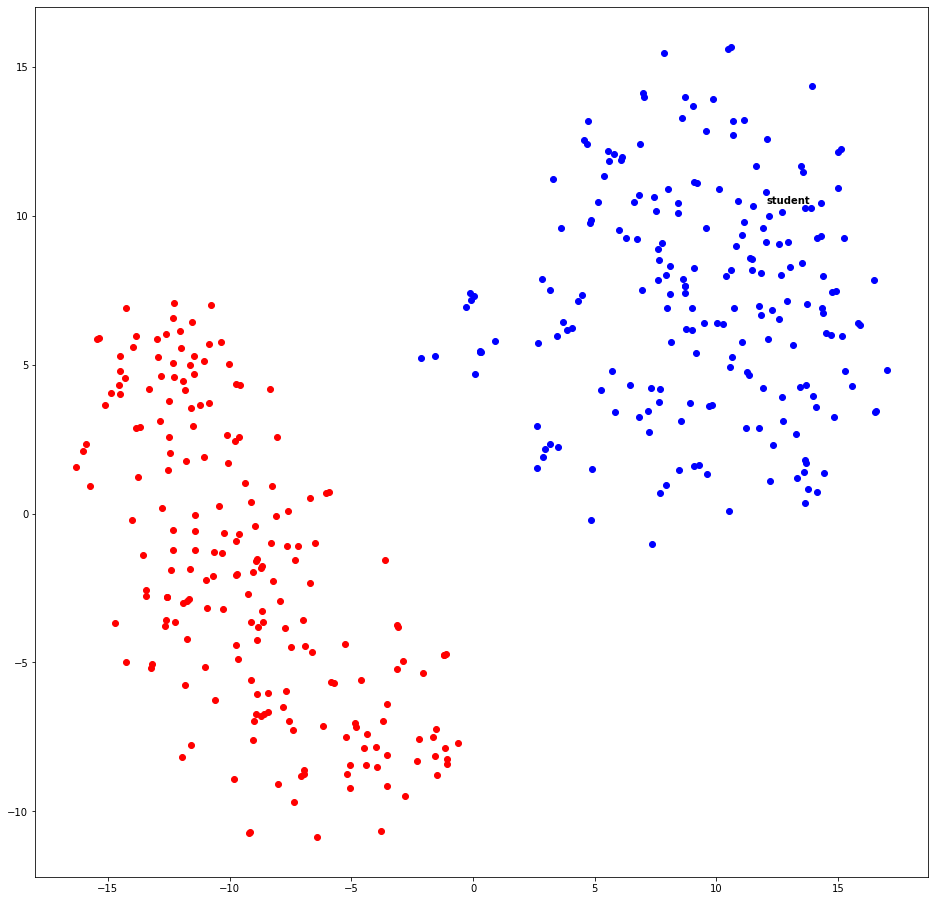

tSNE Clustering Plot (Hard Debiased Embedding): ['black', 'caucasian', 'asian']:


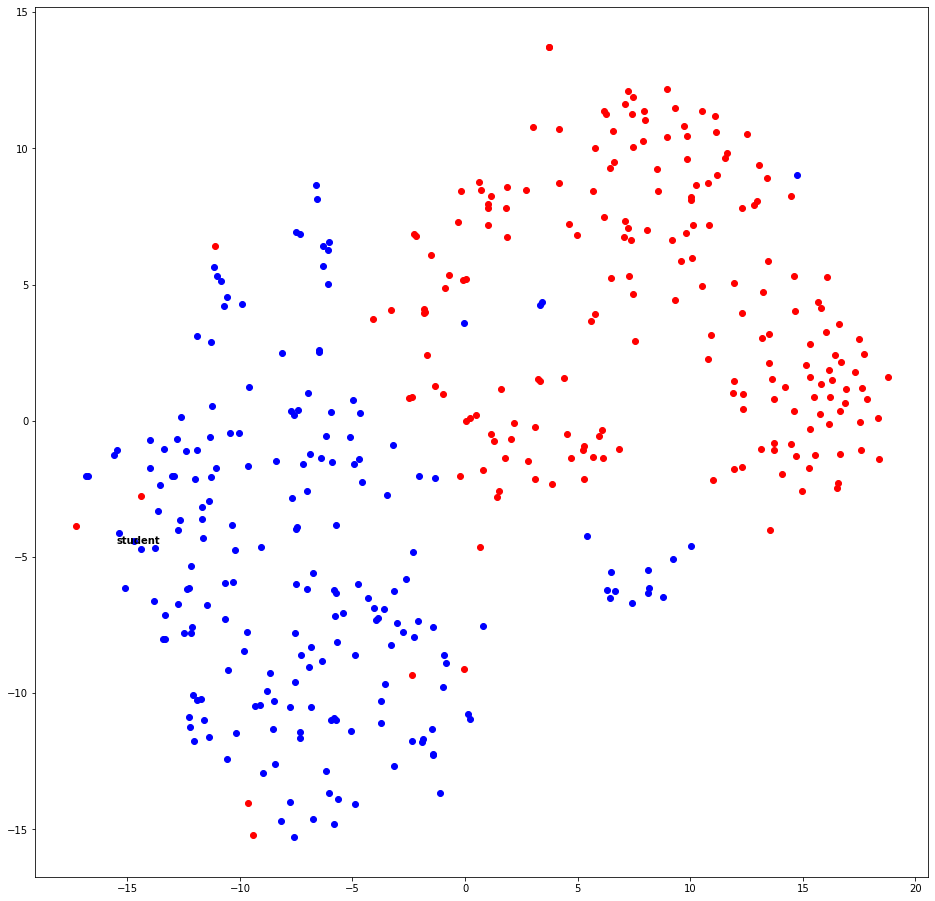

tSNE Clustering Plot (Double-Hard Debiased Embedding): ['black', 'caucasian', 'asian']:


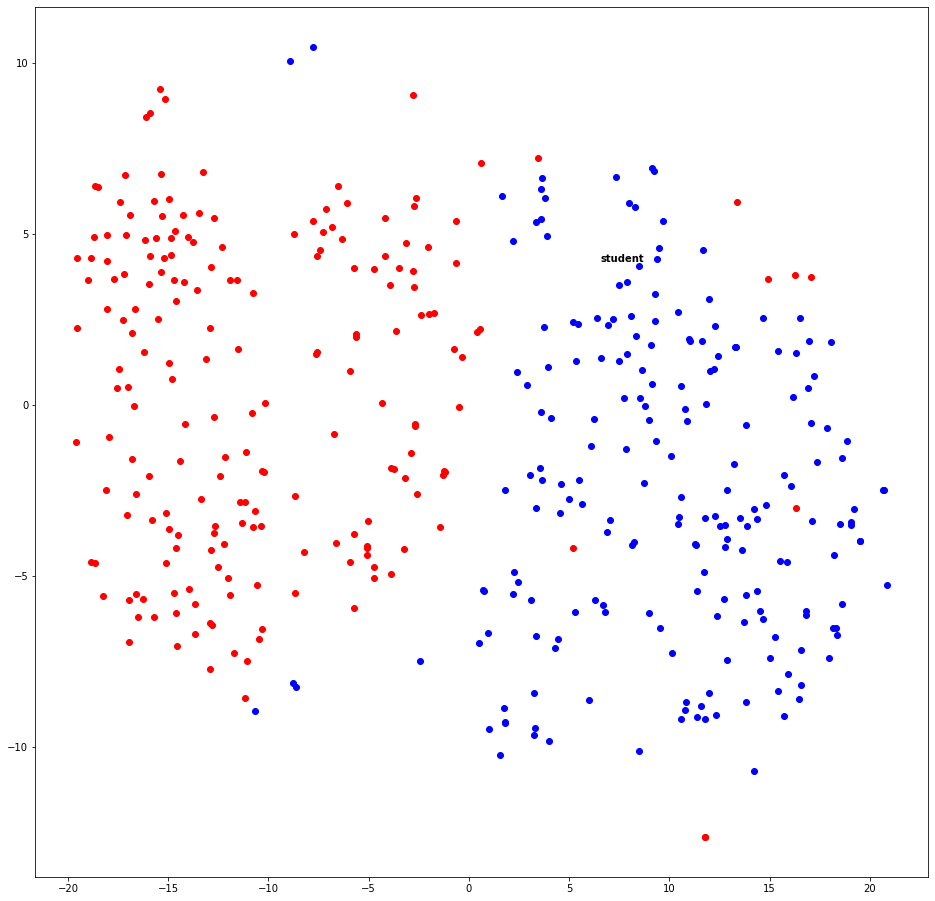


tSNE Clustering Plot (Original Embedding): ['african', 'caucasian', 'asian']:


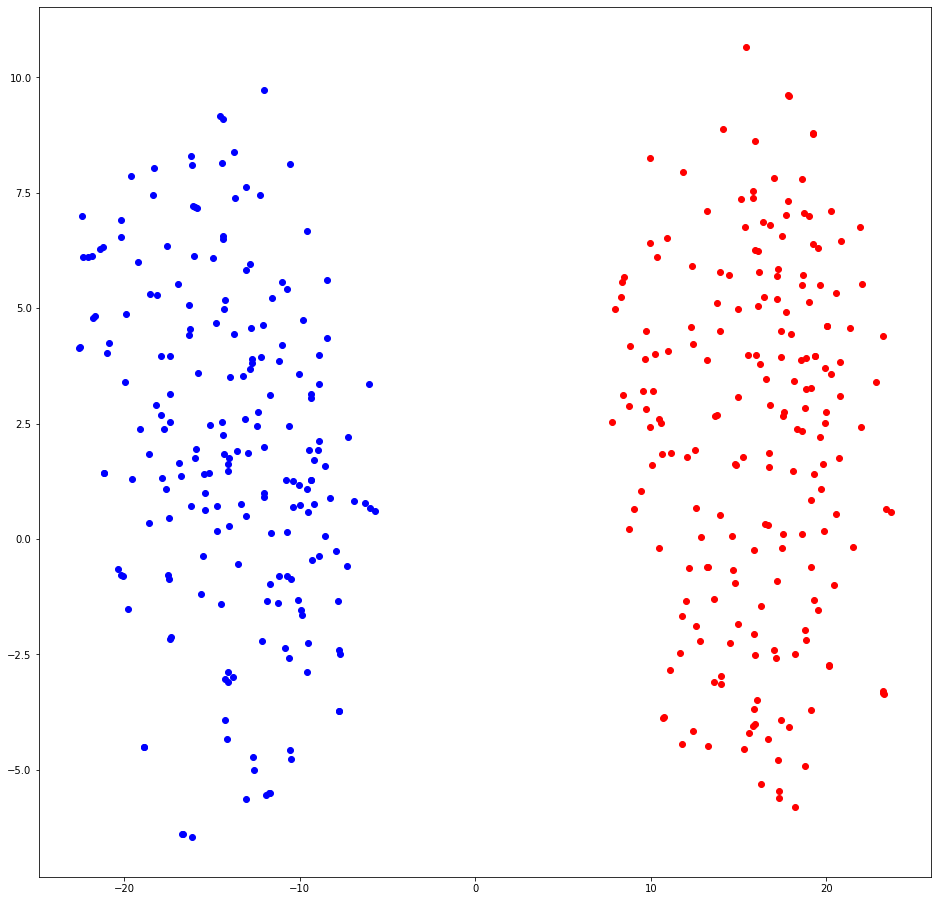

tSNE Clustering Plot (Hard Debiased Embedding): ['african', 'caucasian', 'asian']:


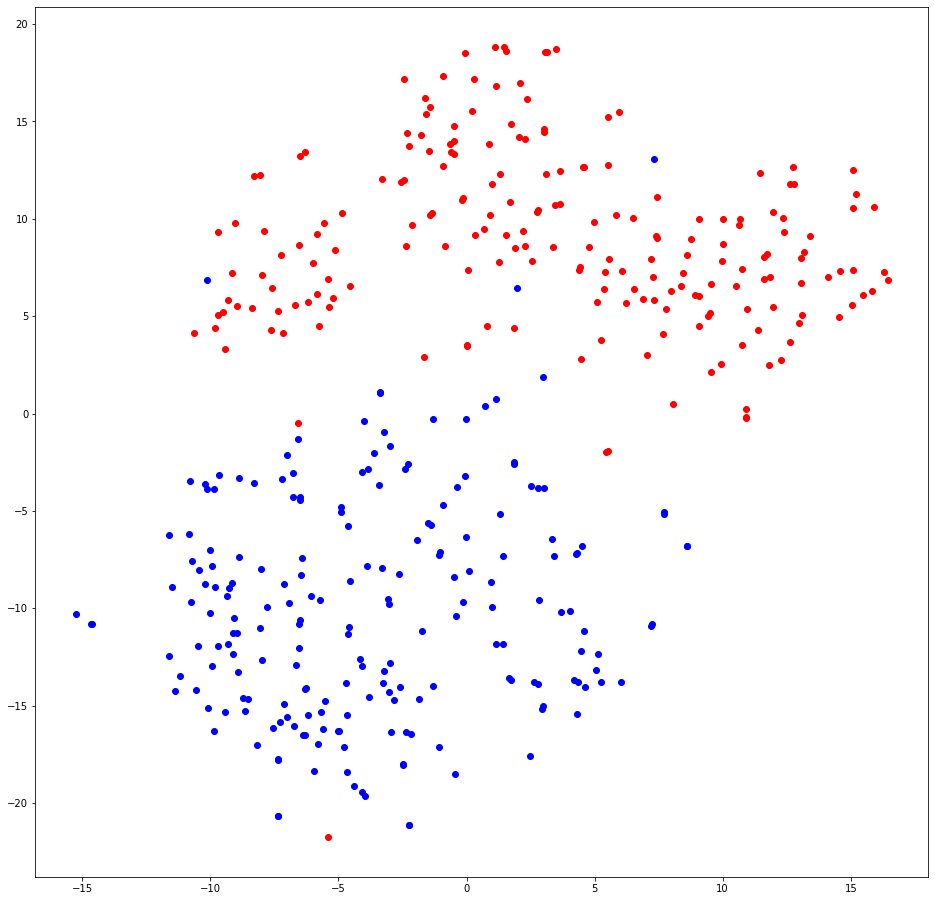

tSNE Clustering Plot (Double-Hard Debiased Embedding): ['african', 'caucasian', 'asian']:


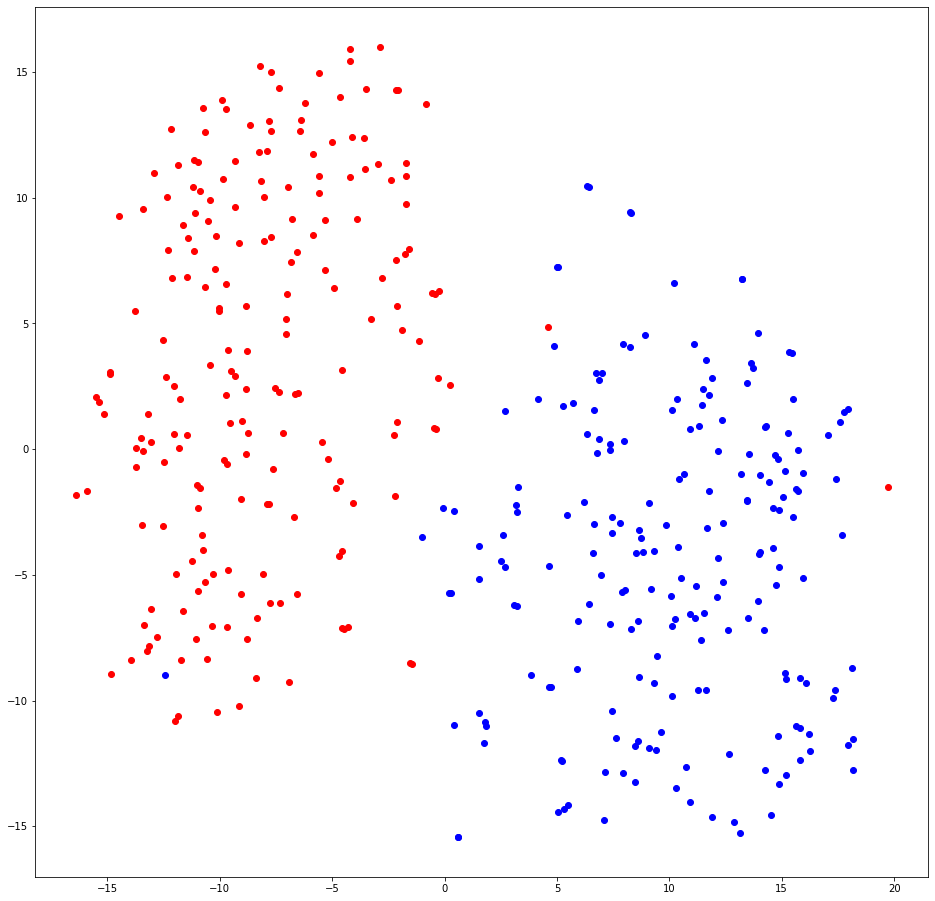


tSNE Clustering Plot (Original Embedding): ['black', 'white', 'asian']:


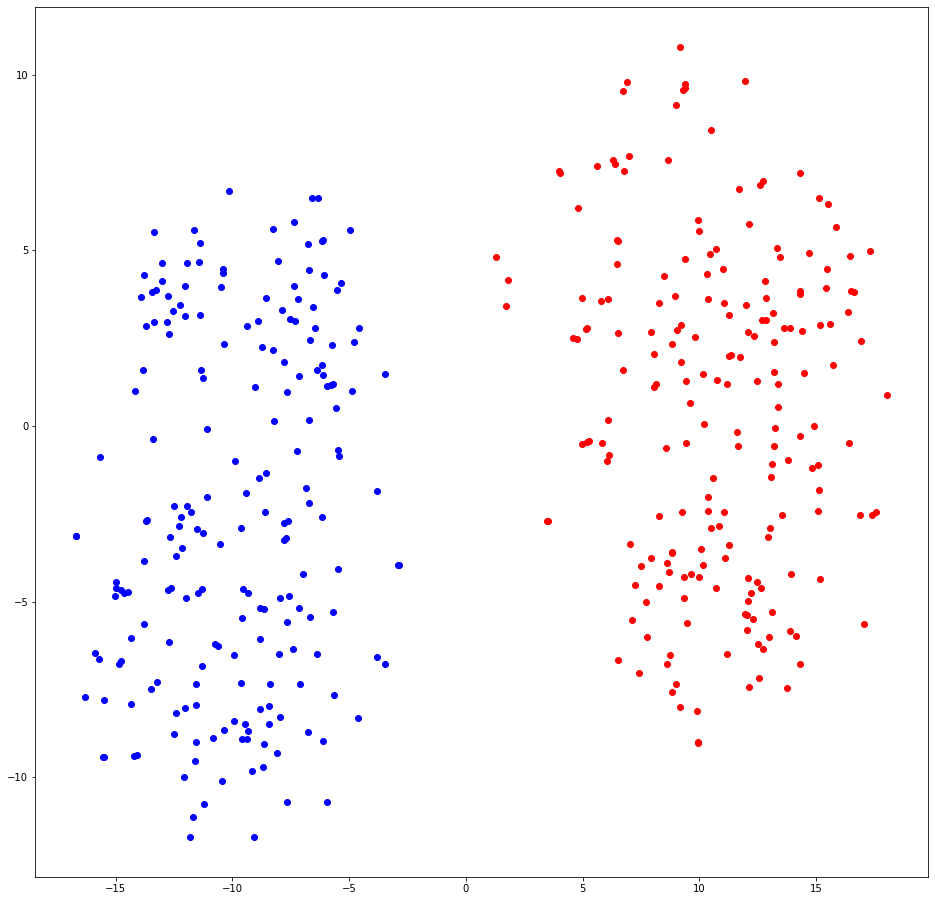

tSNE Clustering Plot (Hard Debiased Embedding): ['black', 'white', 'asian']:


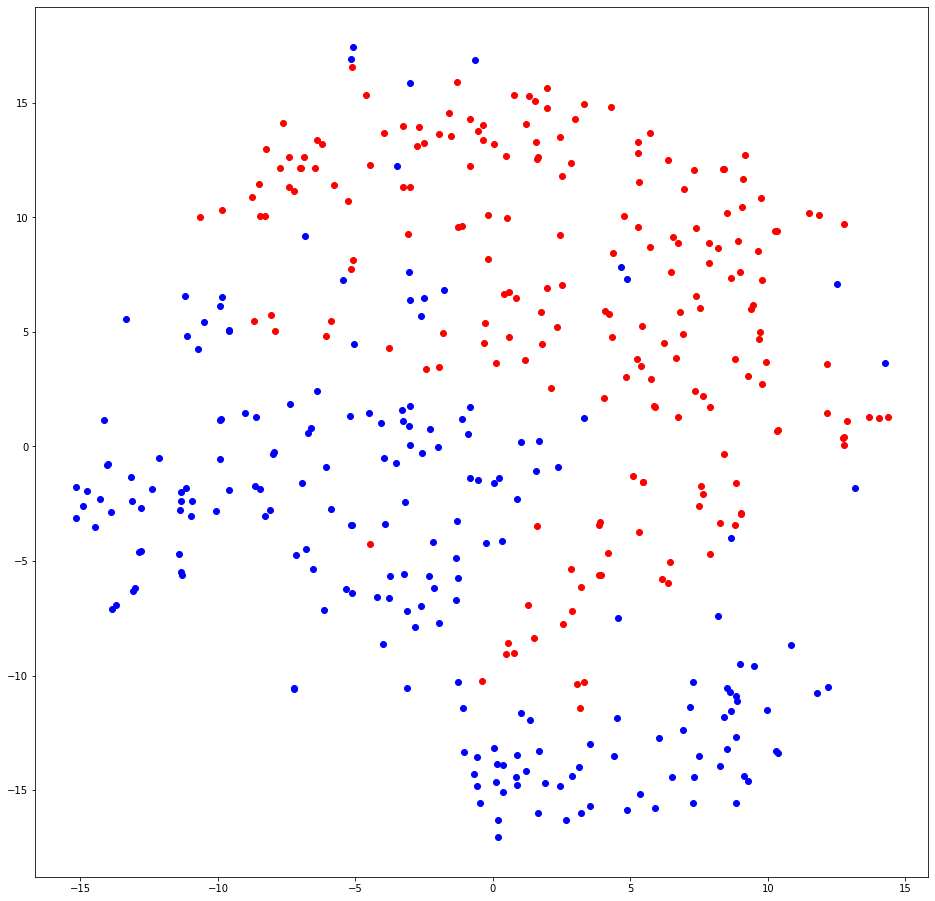

tSNE Clustering Plot (Double-Hard Debiased Embedding): ['black', 'white', 'asian']:


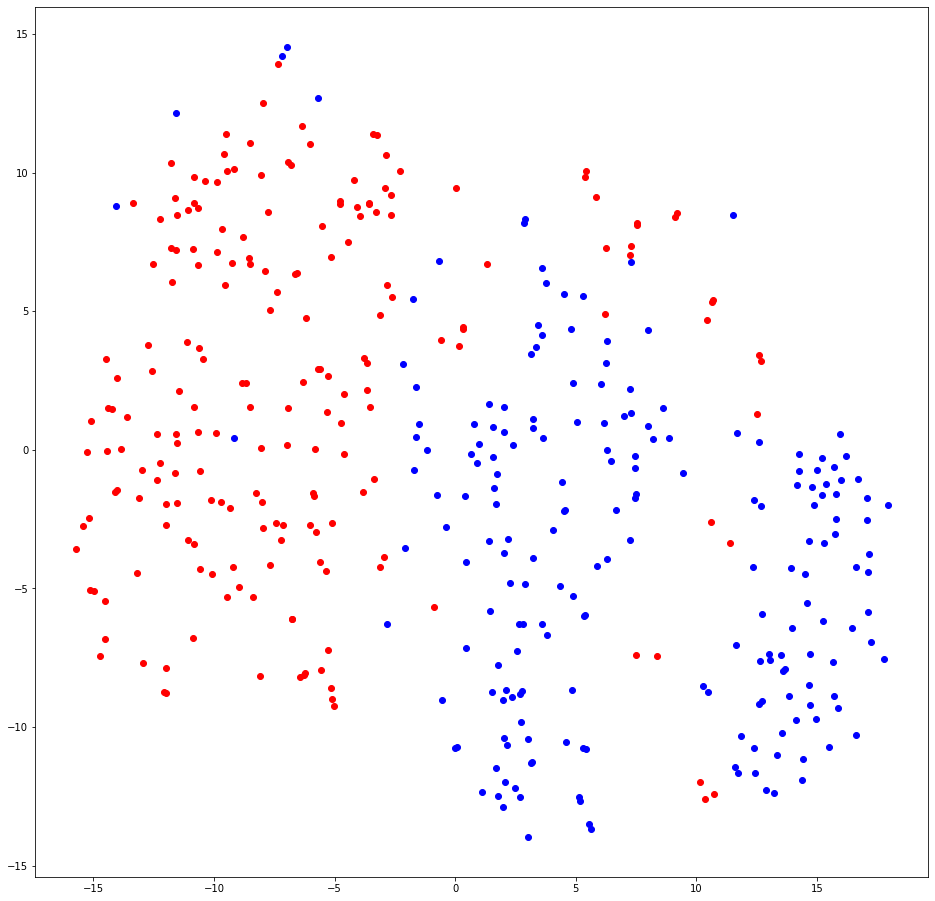


tSNE Clustering Plot (Original Embedding): ['africa', 'america', 'asia']:


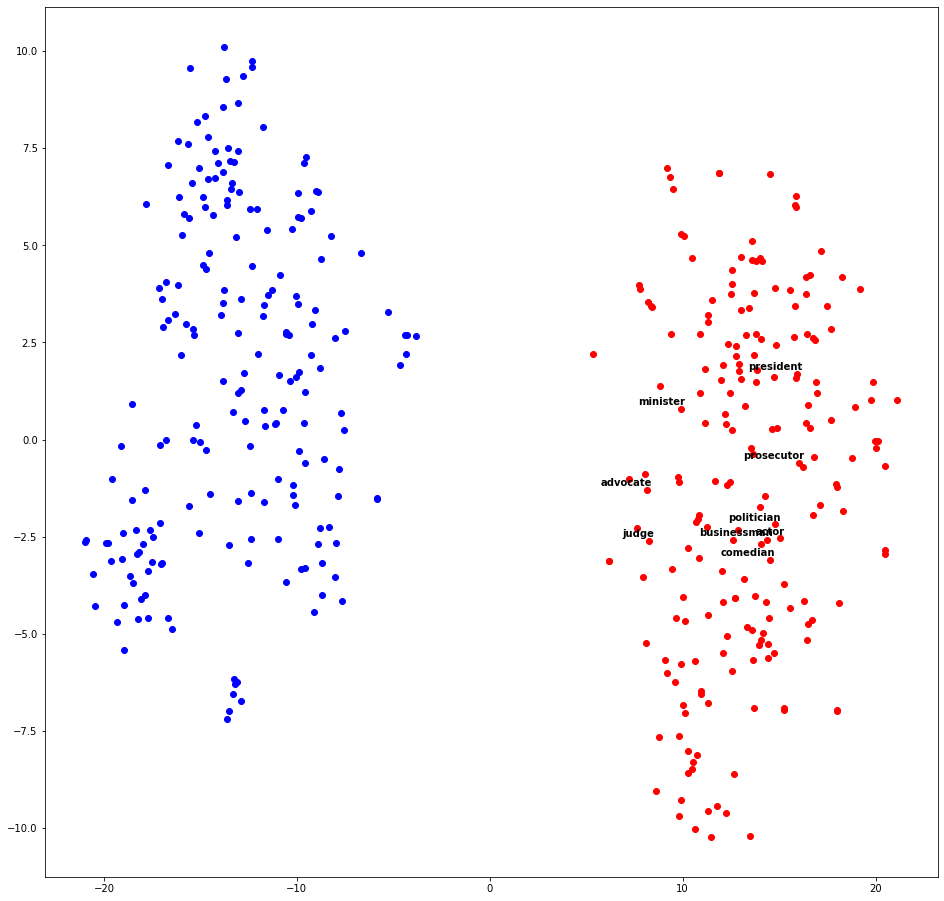

tSNE Clustering Plot (Hard Debiased Embedding): ['africa', 'america', 'asia']:


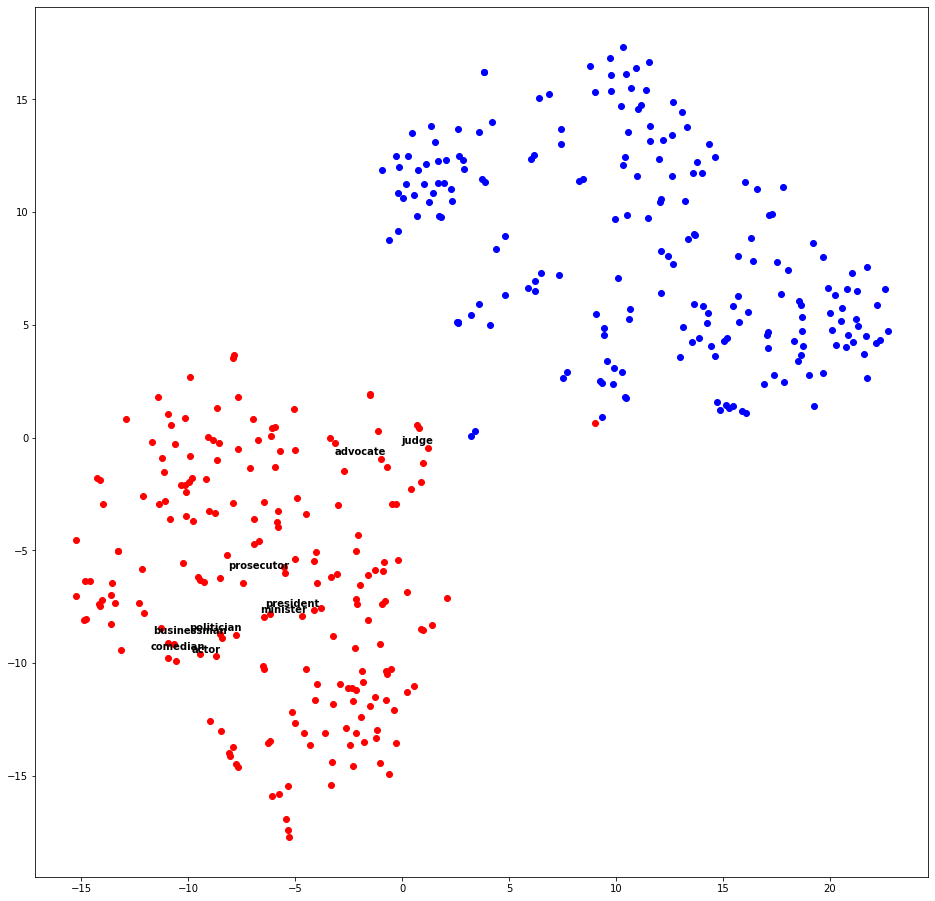

tSNE Clustering Plot (Double-Hard Debiased Embedding): ['africa', 'america', 'asia']:


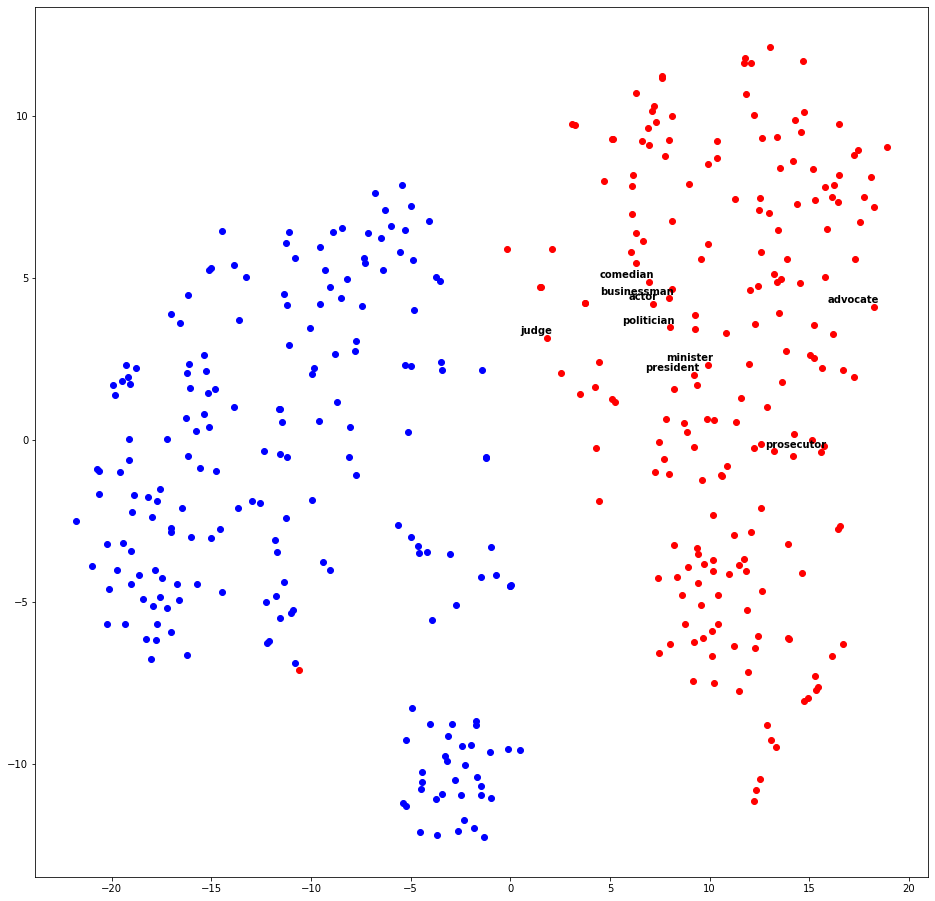


tSNE Clustering Plot (Original Embedding): ['africa', 'america', 'china']:


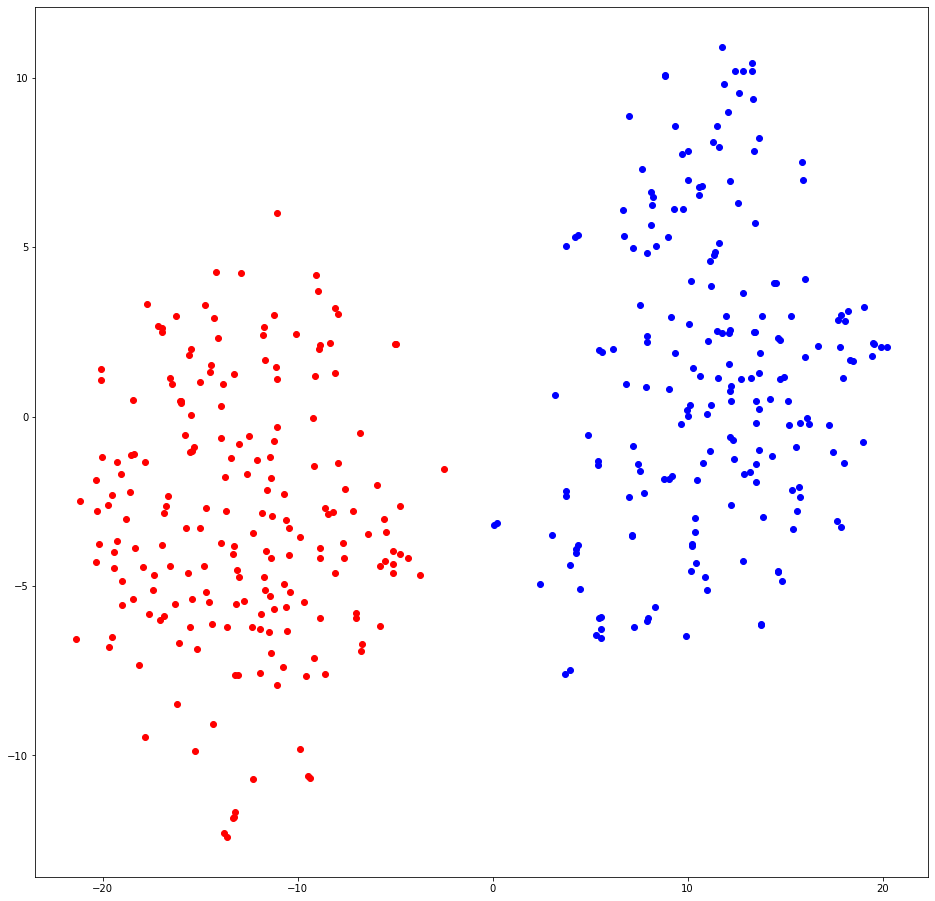

tSNE Clustering Plot (Hard Debiased Embedding): ['africa', 'america', 'china']:


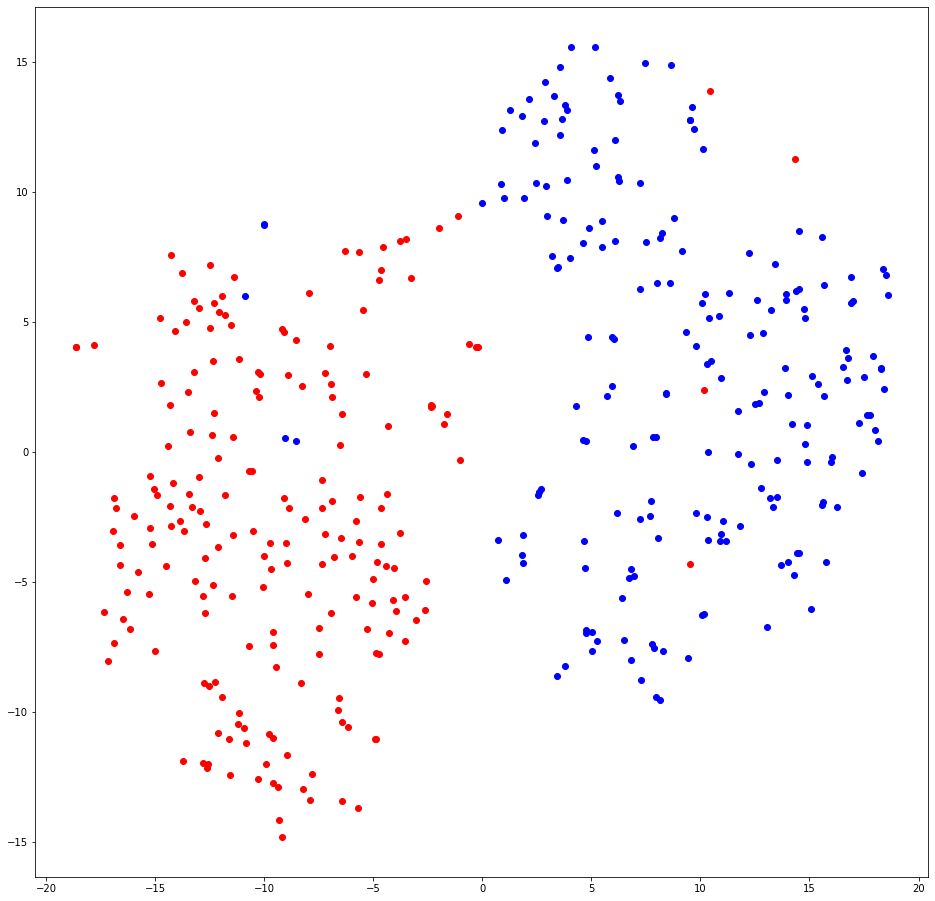

tSNE Clustering Plot (Double-Hard Debiased Embedding): ['africa', 'america', 'china']:


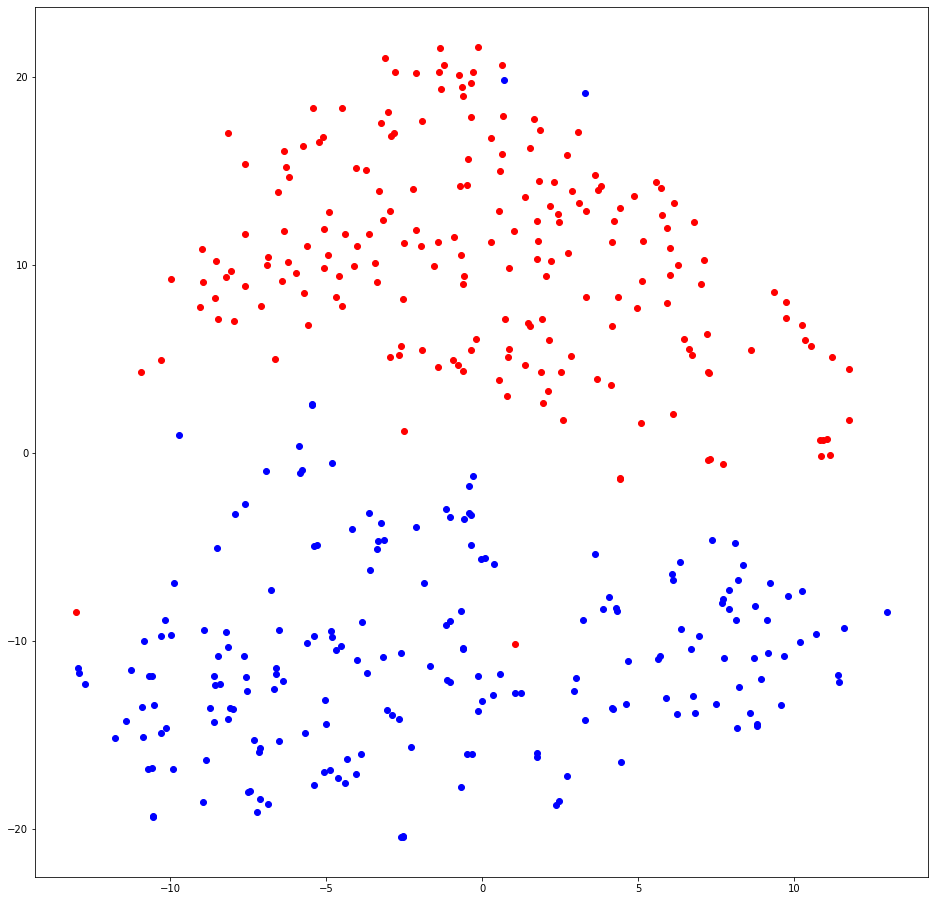


tSNE Clustering Plot (Original Embedding): ['africa', 'europe', 'asia']:


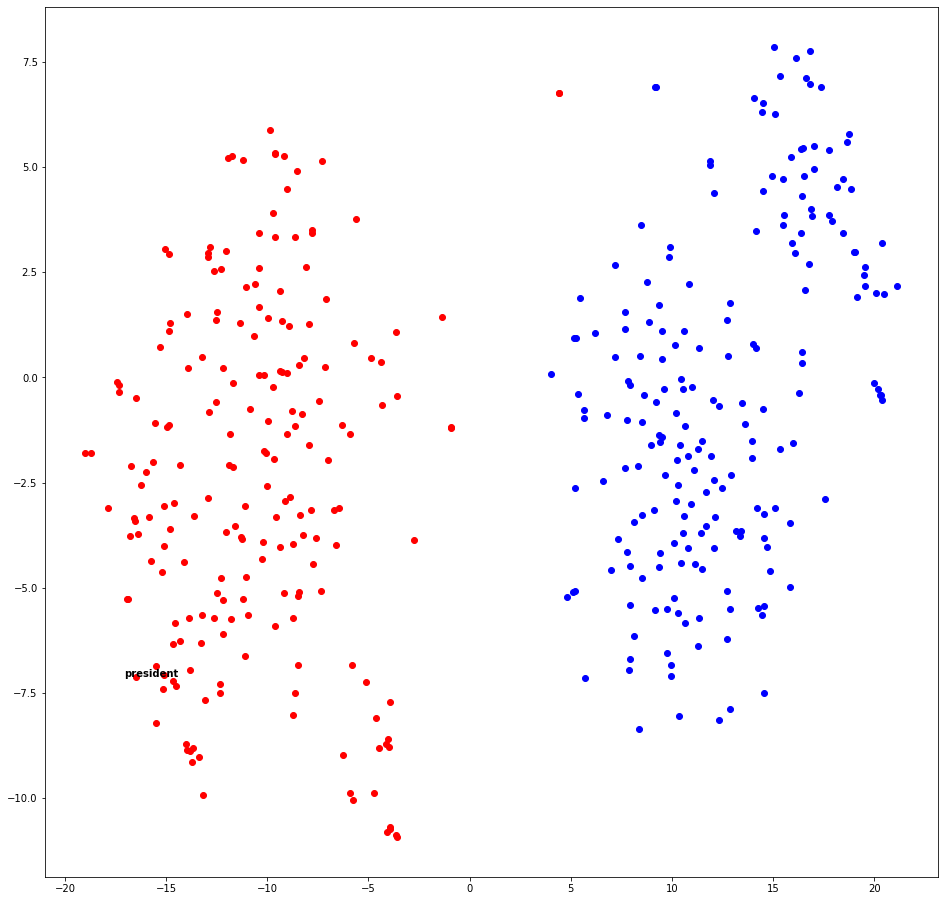

tSNE Clustering Plot (Hard Debiased Embedding): ['africa', 'europe', 'asia']:


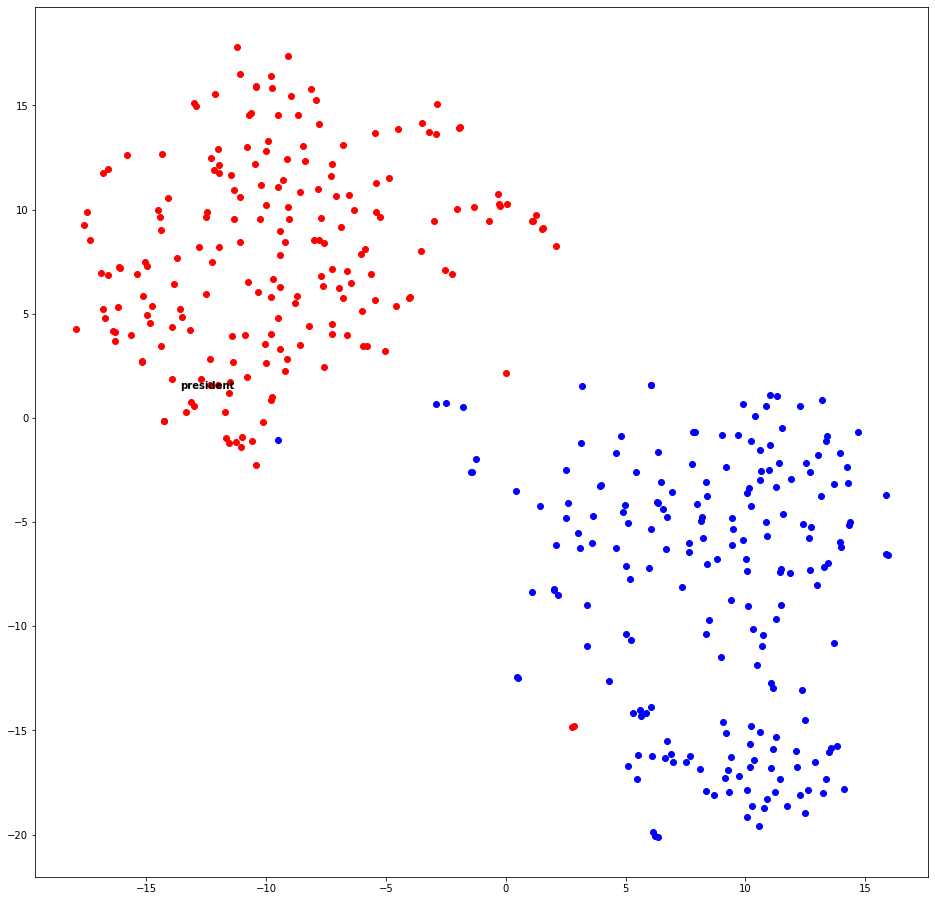

tSNE Clustering Plot (Double-Hard Debiased Embedding): ['africa', 'europe', 'asia']:


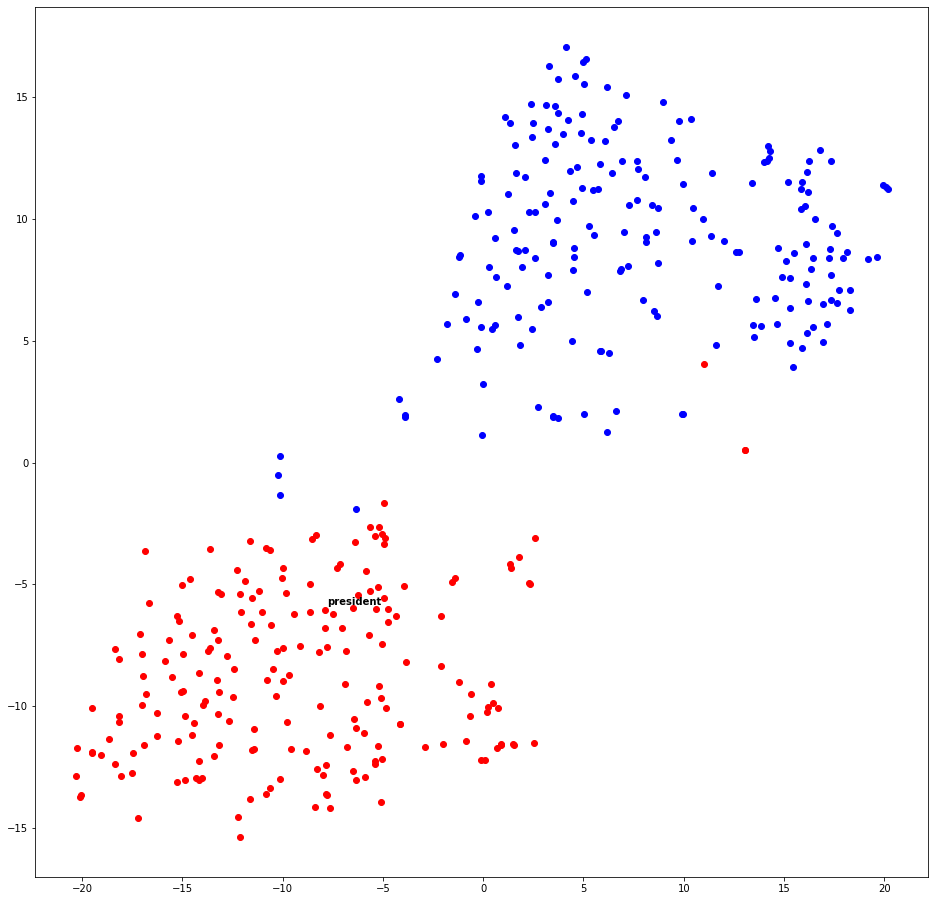

In [20]:
defined_sets = range(0, len(def_sets))

num_words = 200

for d in defined_sets:
    classes = def_sets[d] 
    # Get the subspace/direction for this defined set group
    #directions = get_race_directions(classes, embed_dim, original_vectors)
    
    subspace = identify_bias_subspace(original_vectors, {0:classes}, 1, embed_dim)

    
    # Use the original model to determine the words that have strong positive biases 
    # for each class in the subspace
    positive_words, negative_words = generate_max_biased_words(classes, original_vectors, subspace[0], num_words)
    
    # Flatten positive words to list of words
    biased_words = positive_words + negative_words
    
    # Flatten class values for strong biased words (this will be used for coloring plot)
    color_classes = np.concatenate((np.full((1,len(positive_words)),0), np.full((1,len(negative_words)),1)),1).tolist()[0]
    
    print(f"\ntSNE Clustering Plot (Original Embedding): {def_sets[d]}:")
    tsne_plot(wv_pt, biased_words, set(targets), color_classes)   
    
    print(f"tSNE Clustering Plot (Hard Debiased Embedding): {def_sets[d]}:")
    tsne_plot(wv_hd, biased_words, set(targets), color_classes)
    
    print(f"tSNE Clustering Plot (Double-Hard Debiased Embedding): {def_sets[d]}:")
    tsne_plot(wv_dhd, biased_words, set(targets), color_classes)
        

In [21]:
defined_sets = range(0, len(def_sets))

# Demonstrate that hard debias will reduce number of prediction capabilities for bias (showing that hard debiass is effective)
num_words = 200

for d in defined_sets:
    classes = def_sets[d] 
    # Get the subspace/direction for this defined set group
    directions = get_race_directions(classes, embed_dim, original_vectors)
    subspace = identify_bias_subspace(original_vectors, {0:classes}, 1, embed_dim)
    # Use the original model to determine the words that have strong positive biases 
    # for each class in the subspace
    positive_words, negative_words = generate_max_biased_words(classes, original_vectors, subspace[0], num_words)
    
    x_orig = []
    x_hd = []
    x_dhd = []
    y_true = []

    # for each word get original, hard-db and double-hard db embeddings
    for word in negative_words:
        y_true.append(0)
        x_orig.append(original_vectors[word])
        x_hd.append(debiased_vectors[word])
        x_dhd.append(double_hard_vectors[word])
        
    for word in positive_words:
        y_true.append(1)
        x_orig.append(original_vectors[word])
        x_hd.append(debiased_vectors[word])
        x_dhd.append(double_hard_vectors[word])

    print(f"K-Means Using Strong Bias for Set Values: {def_sets[d]}:")
    precision_orig = cluster(X1=np.array(x_orig), random_state=3, y_true=y_true, num=2)
    precision_hd = cluster(X1=np.array(x_hd), random_state=3, y_true=y_true, num=2)
    precision_dhd = cluster(X1=np.array(x_dhd), random_state=3, y_true=y_true, num=2)
    print(f"Original Precision: {precision_orig}, Hard Debias Precision: {precision_hd}, Double-Hard Debias: {precision_dhd}\n")


K-Means Using Strong Bias for Set Values: ['black', 'caucasian', 'asian']:
Original Precision: 1.0, Hard Debias Precision: 0.8200000000000001, Double-Hard Debias: 0.8175

K-Means Using Strong Bias for Set Values: ['african', 'caucasian', 'asian']:
Original Precision: 1.0, Hard Debias Precision: 0.9375, Double-Hard Debias: 0.9475

K-Means Using Strong Bias for Set Values: ['black', 'white', 'asian']:
Original Precision: 1.0, Hard Debias Precision: 0.665, Double-Hard Debias: 0.67

K-Means Using Strong Bias for Set Values: ['africa', 'america', 'asia']:
Original Precision: 1.0, Hard Debias Precision: 0.985, Double-Hard Debias: 0.97

K-Means Using Strong Bias for Set Values: ['africa', 'america', 'china']:
Original Precision: 0.9975, Hard Debias Precision: 0.9299999999999999, Double-Hard Debias: 0.9299999999999999

K-Means Using Strong Bias for Set Values: ['africa', 'europe', 'asia']:
Original Precision: 1.0, Hard Debias Precision: 0.98, Double-Hard Debias: 0.98

